<a href="https://colab.research.google.com/github/NahidurRahaman/Machine_Learning/blob/main/thesisupdate(KDEF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load FER2013 CSV
csv_path = '/content/drive/MyDrive/FER2013/kdef_train_pixel.csv'  # update path if needed
df = pd.read_csv(csv_path)

In [4]:
# Define emotion classes
emotion_labels = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
    4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

import csv # Import the csv module

# Custom dataset from CSV
class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pixels = list(map(int, self.df.iloc[idx]["pixels"].split()))
        img = np.asarray(pixels).reshape(48, 48).astype(np.uint8)
        img = Image.fromarray(img).convert("L")
        img = img.convert("RGB")  # convert to 3-channel RGB

        if self.transform:
            img = self.transform(img)

        label = int(self.df.iloc[idx]["emotion"])
        return img, label

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(40),                     # rotation_range=40
    transforms.RandomAffine(
        degrees=0,
        translate=(0.25, 0.25),                        # width_shift, height_shift
        shear=0.25,                                    # shear_range=0.25
        scale=(0.75, 1.25),                            # zoom_range=±25%
        fill=0                                         # fill_mode='nearest' (0 means black fill)
    ),
    transforms.RandomHorizontalFlip(p=0.5),            # horizontal_flip=True
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [6]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# =========================
# 1. Augmentation + Normalization
# =========================

# Training transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # random zoom crop
    transforms.RandomHorizontalFlip(),                    # flip
    transforms.RandomRotation(15),                        # rotate
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)                # normalize
])
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Ensure 3 channels for validation as well
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# =========================
# 2. Load FER2013 dataset
# =========================
# Assuming you have FER2013 in 'data/FER2013' folder in csv or folder format
# If folder format:
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/FER2013/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive//FER2013/test', transform=val_transforms)

# =========================
# 3. DataLoaders
# =========================
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# =========================
# 4. Check one batch
# =========================
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)   # [batch_size, channels, height, width]
print("Labels shape:", labels.shape)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


Here is the code for the SRCNN model provided by the user. Note that this model is designed for super-resolution and takes a single-channel image as input and outputs a single-channel image.

In [7]:
import torch.nn as nn
import timm


In [8]:
class EfficientNetV2S_FeatureExtractor(nn.Module):
    def __init__(self):
        super(EfficientNetV2S_FeatureExtractor, self).__init__()
        self.backbone = timm.create_model('tf_efficientnetv2_s.in21k', pretrained=True, features_only=True)

    def forward(self, x):
        features = self.backbone(x)
        return features[-1]  # (B, 1280, 7, 7)

In [9]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
efficientnet_model = EfficientNetV2S_FeatureExtractor().to(device)
efficientnet_model.eval()

# Use first batch from train_loader
for images, labels in train_loader:
    images = images.to(device)  # shape: (B, 3, 224, 224)
    labels = labels.to(device)

    with torch.no_grad():
        features = efficientnet_model(images)  # shape: (B, 1280, 7, 7)

    print("Input shape:", images.shape)
    print("EfficientNetV2-S Output shape:", features.shape)
    break

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/193M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Input shape: torch.Size([16, 3, 224, 224])
EfficientNetV2-S Output shape: torch.Size([16, 256, 7, 7])


In [11]:
class ConvNeXtBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super(ConvNeXtBlock, self).__init__()
        self.convnext = timm.create_model('convnext_tiny', pretrained=True, features_only=True)
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.proj(x)  # Reduce 256 → 256 (no change)
        return x  # shape: B × 256 × 7 × 7

In [12]:
class SE_MBConvBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super(SE_MBConvBlock, self).__init__()
        self.expand = nn.Conv2d(in_channels, in_channels * 6, kernel_size=1)
        self.depthwise = nn.Conv2d(in_channels * 6, in_channels * 6, kernel_size=3, padding=1, groups=in_channels * 6)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * 6, in_channels // 4, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 4, in_channels * 6, 1),
            nn.Sigmoid()
        )
        self.project = nn.Conv2d(in_channels * 6, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.expand(x)
        x = self.depthwise(x)
        se_weight = self.se(x)
        x = x * se_weight
        x = self.project(x)
        return x  # shape: B × 256 × 7 × 7

In [13]:
adaptive_pool = nn.AdaptiveAvgPool2d((28, 28))


In [14]:
class MultiBranchFeatureExtractor(nn.Module):
    def __init__(self):
        super(MultiBranchFeatureExtractor, self).__init__()
        self.efficientnet = EfficientNetV2S_FeatureExtractor()
        self.convnext_block = ConvNeXtBlock()
        self.se_mbconv_block = SE_MBConvBlock()
        self.pool = nn.AdaptiveAvgPool2d((28, 28))  # Resize to 28×28

    def forward(self, x):
        x = self.efficientnet(x)  # Output: B × 1280 × 7 × 7

        convnext_feat = self.convnext_block(x)     # B × 256 × 7 × 7
        senet_feat    = self.se_mbconv_block(x)    # B × 256 × 7 × 7

        convnext_feat = self.pool(convnext_feat)   # B × 256 × 28 × 28
        senet_feat    = self.pool(senet_feat)      # B × 256 × 28 × 28

        return convnext_feat, senet_feat


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiBranchFeatureExtractor().to(device)
model.eval()

for images, labels in train_loader:
    images = images.to(device)

    with torch.no_grad():
        conv_feat, se_feat = model(images)

    print("ConvNeXt Output:", conv_feat.shape)  # [B, 256, 28, 28]
    print("SENet+MBConv Output:", se_feat.shape)  # [B, 256, 28, 28]
    break


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

ConvNeXt Output: torch.Size([16, 256, 28, 28])
SENet+MBConv Output: torch.Size([16, 256, 28, 28])


In [16]:
class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim=256, num_heads=4):
        super(CrossAttentionFusion, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, feat_q, feat_kv):
        # Input: B × 256 × 28 × 28
        B, C, H, W = feat_q.shape

        # Flatten to sequences: B × 784 × 256
        q = feat_q.view(B, C, -1).permute(0, 2, 1)   # Q: (B, 784, 256)
        kv = feat_kv.view(B, C, -1).permute(0, 2, 1) # K,V: (B, 784, 256)

        # Cross-attention
        attn_output, _ = self.attn(q, kv, kv)        # (B, 784, 256)
        attn_output = self.norm(attn_output + q)     # Residual + Norm

        # Reshape back to spatial map: (B, 256, 28, 28)
        fused = attn_output.permute(0, 2, 1).view(B, C, H, W)

        return fused  # Output: B × 256 × 28 × 28

In [17]:
class FullFeatureFusionBlock(nn.Module):
    def __init__(self):
        super(FullFeatureFusionBlock, self).__init__()
        self.backbone = MultiBranchFeatureExtractor()        # Gives conv_feat, se_feat
        self.cross_attn = CrossAttentionFusion(embed_dim=256, num_heads=4)

    def forward(self, x):
        conv_feat, se_feat = self.backbone(x)               # B × 256 × 28 × 28

        fused_feat = self.cross_attn(conv_feat, se_feat)    # B × 256 × 28 × 28

        return fused_feat  # ready for concatenation with other branches if needed

In [18]:
model = FullFeatureFusionBlock().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        fused_output = model(images)

    print("Fused Output Shape:", fused_output.shape)  # Expected: [B, 256, 28, 28]
    break

Fused Output Shape: torch.Size([16, 256, 28, 28])


In [19]:
class GlobalContextBranch(nn.Module):
    def __init__(self, in_channels=256, out_channels=64):
        super(GlobalContextBranch, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.ReLU(),
            nn.Upsample(size=(28, 28), mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        x = self.global_pool(x)   # [B, 256, 1, 1] after global pool, originally [B, 256, 7, 7]
        x = self.fc(x)            # [B, 64, 28, 28]
        return x

In [20]:
class LocalDetailBranch(nn.Module):
    def __init__(self, in_channels=256, out_channels=64):
        super(LocalDetailBranch, self).__init__()
        self.local_cnn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.local_cnn(x)  # [B, 64, 28, 28]

In [21]:
class MultiBranchFullFusion(nn.Module):
    def __init__(self):
        super(MultiBranchFullFusion, self).__init__()
        self.feature_extractor = EfficientNetV2S_FeatureExtractor()

        self.convnext_block = ConvNeXtBlock()
        self.se_mbconv_block = SE_MBConvBlock()

        self.pool = nn.AdaptiveAvgPool2d((28, 28))
        self.cross_attn = CrossAttentionFusion(embed_dim=256)

        self.global_context = GlobalContextBranch()
        self.local_detail = LocalDetailBranch()

        # Add pooling to ensure consistent spatial dimensions before concatenation
        self.global_pool_out = nn.AdaptiveAvgPool2d((28, 28))
        self.local_pool_out = nn.AdaptiveAvgPool2d((28, 28))


    def forward(self, x):
        feat = self.feature_extractor(x)                # [B, 256, 7, 7]

        # ConvNeXt & SENet+MBConv
        conv_feat = self.pool(self.convnext_block(feat))  # [B, 256, 28, 28]
        se_feat   = self.pool(self.se_mbconv_block(feat)) # [B, 256, 28, 28]

        # Cross-attention fused output
        fused_attn = self.cross_attn(conv_feat, se_feat)  # [B, 256, 28, 28]

        # Extra branches
        global_feat = self.global_context(feat)           # Expected: [B, 64, 28, 28]
        local_feat  = self.local_detail(feat)             # Expected: [B, 64, 28, 28]

        # Ensure spatial dimensions are 28x28 before concatenation
        global_feat_pooled = self.global_pool_out(global_feat)
        local_feat_pooled = self.local_pool_out(local_feat)


        # Concatenate all
        final_feat = torch.cat([conv_feat, se_feat, fused_attn, global_feat_pooled, local_feat_pooled], dim=1)  # [B, 896, 28, 28]
        return final_feat

In [22]:
model = MultiBranchFullFusion().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        fusion_output = model(images)
    print("Final Fused Feature Shape:", fusion_output.shape)  # [B, 896, 28, 28]
    break


Final Fused Feature Shape: torch.Size([16, 896, 28, 28])


In [23]:
class MobileViTBlock(nn.Module):
    def __init__(self, in_channels, transformer_dim=128, patch_size=2, depth=2, heads=4):
        super(MobileViTBlock, self).__init__()
        self.patch_size = patch_size
        ph, pw = patch_size, patch_size

        self.local_rep = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )

        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        self.fold = nn.Fold(output_size=(28, 28), kernel_size=patch_size, stride=patch_size)

        self.conv_before_trans = nn.Conv2d(in_channels * ph * pw, transformer_dim, kernel_size=1)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_dim,
            nhead=heads,
            batch_first=True,
            dim_feedforward=transformer_dim * 2,
            dropout=0.1,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.conv_after_trans = nn.Conv2d(transformer_dim, in_channels * ph * pw, kernel_size=1)


        self.project = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )

    def forward(self, x):
        B, C, H, W = x.shape
        ph, pw = self.patch_size, self.patch_size

        identity = x # B × C × H × W

        x = self.local_rep(x) # B × C × H × W

        # Unfold, Conv, and flatten for Transformer
        x = self.unfold(x) # B × (C*ph*pw) × (H*W / (ph*pw))
        x = x.view(B, C, ph*pw, -1).permute(0, 3, 2, 1).contiguous().view(B, -1, C*ph*pw) # B × N × (C*ph*pw)
        x = self.conv_before_trans(x.permute(0, 2, 1).view(B, C*ph*pw, H//ph, W//pw)).view(B, self.conv_before_trans.out_channels, -1).permute(0, 2, 1) # B × N × transformer_dim


        # Transformer
        x = self.transformer(x) # B × N × transformer_dim

        # Project back and Fold
        x = self.conv_after_trans(x.permute(0, 2, 1).view(B, self.conv_after_trans.in_channels, H//ph, W//pw)) # B × (C*ph*pw) × H/ph × W/pw
        x = x.view(B, C*ph*pw, -1) # B × (C*ph*pw) × N
        x = self.fold(x) # B × C × H × W

        # Project and Residual Connection
        x = self.project(x) # B × C × H × W
        x = x + identity # Residual connection

        return x # B × in_channels × H × W

In [24]:
class FinalModelWithMobileViT(nn.Module):
    def __init__(self):
        super(FinalModelWithMobileViT, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)

    def forward(self, x):
        x = self.fusion(x)         # [B, 896, 28, 28]
        x = self.mobilevit(x)      # [B, 896, 28, 28]
        return x


In [25]:
class FinalModelWithMobileViT1(nn.Module):
    def __init__(self):
        super(FinalModelWithMobileViT1, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=(2,2), depth=2, heads=4)

    def forward(self, x):
        x = self.fusion(x)         # [B, 896, 28, 28]
        x = self.mobilevit(x)      # [B, 896, 28, 28]
        return x

In [26]:
class FinalModelWithGAP(nn.Module):
    def __init__(self):
        super(FinalModelWithGAP, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Avg Pool → [B, 896, 1, 1]

    def forward(self, x):
        x = self.fusion(x)            # [B, 896, 28, 28]
        x = self.mobilevit(x)         # [B, 896, 28, 28]
        x = self.gap(x)               # [B, 896, 1, 1]
        x = x.view(x.size(0), -1)     # Flatten → [B, 896]
        return x


In [27]:
model = FinalModelWithGAP().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        features = model(images)

    print("Final Feature Vector Shape:", features.shape)  # [B, 896]
    break

Final Feature Vector Shape: torch.Size([16, 896])


In [28]:
class EmotionClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(EmotionClassifier, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),                 # [B, 896, 1, 1] → [B, 896]
            nn.Dropout(dropout_rate),
            nn.Linear(896, 7)            # 7 emotion classes
        )

    def forward(self, x):
        x = self.fusion(x)            # [B, 896, 28, 28]
        x = self.mobilevit(x)         # [B, 896, 28, 28]
        x = self.gap(x)               # [B, 896, 1, 1]
        x = self.classifier(x)        # [B, 7]
        return x


In [29]:
model = EmotionClassifier().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        logits = model(images)

    print("Model Output Shape:", logits.shape)  # [B, 7]
    break


Model Output Shape: torch.Size([16, 7])


In [34]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=25, patience=5):
    best_val_loss = float('inf')
    best_epoch = 0
    epochs_no_improve = 0
    # Initialize history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = 100 * train_correct / total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / val_total
        val_acc = 100 * val_correct / val_total

        # Step scheduler
        scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Saved Best Model")
        else:
            epochs_no_improve += 1



        # Append history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)


    print("Training Complete!")
    return history

In [35]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.5)

In [36]:
num_epochs = 50  # or as needed
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=50,

)



Epoch [1/25] | Train Loss: 0.5116 | Train Acc: 98.38% | Val Loss: 0.7351 | Val Acc: 88.93%
✅ Saved Best Model
Epoch [2/25] | Train Loss: 0.5165 | Train Acc: 98.17% | Val Loss: 0.7272 | Val Acc: 86.88%
✅ Saved Best Model
Epoch [3/25] | Train Loss: 0.5121 | Train Acc: 98.30% | Val Loss: 0.7648 | Val Acc: 86.88%
Epoch [4/25] | Train Loss: 0.4967 | Train Acc: 98.64% | Val Loss: 0.8618 | Val Acc: 82.62%
Epoch [5/25] | Train Loss: 0.5034 | Train Acc: 98.26% | Val Loss: 0.8186 | Val Acc: 84.84%
Epoch [6/25] | Train Loss: 0.4937 | Train Acc: 98.77% | Val Loss: 0.8043 | Val Acc: 83.30%
Epoch [7/25] | Train Loss: 0.4882 | Train Acc: 98.81% | Val Loss: 0.8148 | Val Acc: 84.16%
Epoch [8/25] | Train Loss: 0.4879 | Train Acc: 98.60% | Val Loss: 0.8587 | Val Acc: 82.28%
Epoch [9/25] | Train Loss: 0.5055 | Train Acc: 98.09% | Val Loss: 0.7848 | Val Acc: 84.84%
Epoch [10/25] | Train Loss: 0.4876 | Train Acc: 98.68% | Val Loss: 0.8621 | Val Acc: 82.28%
Epoch [11/25] | Train Loss: 0.4860 | Train Acc: 98.

In [41]:
import matplotlib.pyplot as plt

def plot_training(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


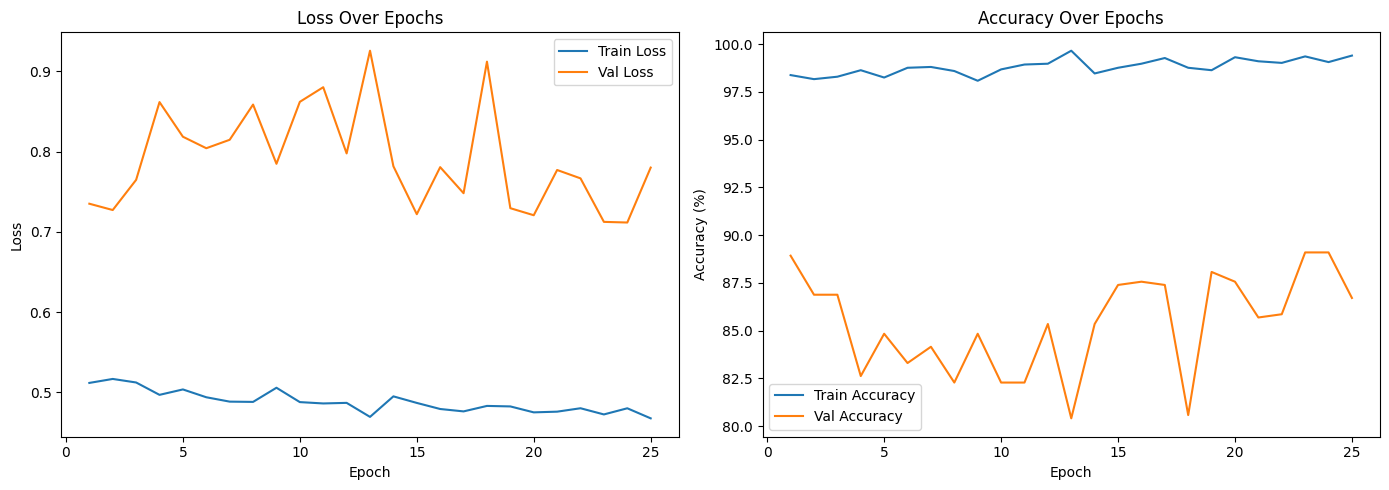

In [42]:
plot_training(history)

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def evaluate_on_test(model, train_loader, device, class_names=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Define all possible labels (0 to 6 for FER2013)
    all_possible_labels = list(range(len(class_names))) if class_names else sorted(list(set(all_labels + all_preds)))

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, labels=all_possible_labels, zero_division=0)) # Added labels and zero_division

    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=all_possible_labels) # Added labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



📊 Classification Report:
              precision    recall  f1-score   support

       Angry       0.99      1.00      0.99       332
     Disgust       1.00      0.99      0.99       332
        Fear       1.00      0.99      1.00       332
       Happy       1.00      1.00      1.00       340
         Sad       0.99      1.00      0.99       332
    Surprise       1.00      1.00      1.00       352
     Neutral       1.00      1.00      1.00       331

    accuracy                           1.00      2351
   macro avg       1.00      1.00      1.00      2351
weighted avg       1.00      1.00      1.00      2351



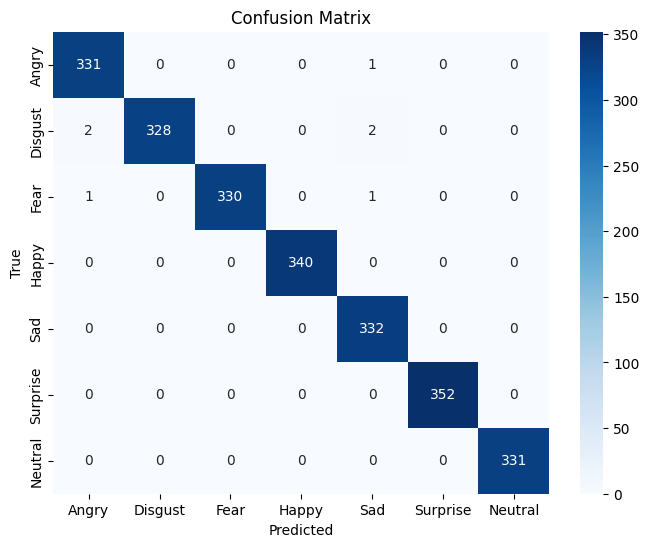

In [44]:
class_names = ['Angry', 'Disgust', 'Fear','Happy', 'Sad', 'Surprise', 'Neutral']
model.load_state_dict(torch.load("best_model.pth"))
evaluate_on_test(model, train_loader, device, class_names)
